
## This Notebook is a sort of tutorial for the beginners in Deep Learning and time-series data analysis. 

##  * The aim is just to show how to build the simplest Long Short-Term Memory (LSTM) recurrent neural network for the data.  
 
### * Jupyter notebook can be downloaded here: https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-

The description of data can be found here:
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [4]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout


In [5]:
## Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
## Just open the zip file and grab the file 'household_power_consumption.txt' put it in the directory 
## that you would like to run the code. 


df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Dia', 'Mês', 'Ano']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.index = df.index.tz_localize("America/Sao_Paulo")

weather_df = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, infer_datetime_format=True, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')


weather_df = weather_df[weather_df.index >= '2022-01-07']
weather_weekly_df = pd.DataFrame(weather_df[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].resample('W').mean())

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]

#filtered_alface_crespa_roca = filtered_alface_crespa_roca[(filtered_alface_crespa_roca.index >= '2022-01-01') & (filtered_alface_crespa_roca.index < '2023-01-01')]
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)

#filtered_alface_crespa_roca.insert(1, 'precip', weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].tolist())

#pd.concat([filtered_alface_crespa_roca, weather_weekly_df], axis=1)

filtered_alface_crespa_roca
#weather_weekly_df.head()
#weather_weekly_df

#weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

/tmp/ipykernel_167811/3528887800.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',',
/tmp/ipykernel_167811/3528887800.py:6: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',',
/tmp/ipykernel_167811/3528887800.py:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather_df = pd.read_csv('../

,Preco_unitario
dt,
2016-04-22 00:00:00-03:00,0.61650
2016-04-29 00:00:00-03:00,0.42611
2016-05-06 00:00:00-03:00,0.43778
2016-05-13 00:00:00-03:00,0.43056
2016-05-20 00:00:00-03:00,0.44444
...,...
2023-08-25 00:00:00-03:00,0.40833
2023-08-31 00:00:00-03:00,0.37500
2023-09-08 00:00:00-03:00,0.35417


 ## 1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same. 

## 2) I merged two columns 'Date' and 'Time' to 'dt'. 

## 3) I also converted in the above, the data to time-series type, by taking index to be the time. 

In [6]:
df.head() 

,Produto,Região,Moeda,Unidade,Preco,Preco_unitario
dt,,,,,,
2023-09-22 00:00:00-03:00,Alface Americana - Roça,Teresópolis (região),R$,12,7.5,0.62500
2023-09-22 00:00:00-03:00,Alface Crespa - Roça,Teresópolis (região),R$,24,9.8,0.40833
2023-09-22 00:00:00-03:00,Alface Lisa - Roça,Teresópolis (região),R$,24,9.8,0.40833
2023-09-15 00:00:00-03:00,Alface Americana - Roça,Teresópolis (região),R$,12,6.4,0.53333
2023-09-15 00:00:00-03:00,Alface Crespa - Roça,Teresópolis (região),R$,24,8.0,0.33333


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1120 entries, 2023-09-22 00:00:00-03:00 to 2016-04-22 00:00:00-03:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Produto         1120 non-null   object 
 1   Região          1120 non-null   object 
 2   Moeda           1120 non-null   object 
 3   Unidade         1120 non-null   int64  
 4   Preco           1120 non-null   float64
 5   Preco_unitario  1120 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 61.2+ KB


In [8]:
df.dtypes

Produto            object
Região             object
Moeda              object
Unidade             int64
Preco             float64
Preco_unitario    float64
dtype: object

In [9]:
df.shape

(1120, 6)

In [10]:
df.describe()

,Unidade,Preco,Preco_unitario
count,1120.000000,1120.000000,1120.000000
mean,17.541071,10.560036,0.629997
std,4.573705,5.632966,0.340388
min,12.000000,3.380000,0.187780
25%,12.000000,6.897500,0.379163
50%,18.000000,9.000000,0.549445
75%,24.000000,12.000000,0.784580
max,24.000000,38.500000,3.208330


In [8]:
df.columns

Index(['Produto', 'Região', 'Moeda', 'Unidade', 'Preco', 'Preco_unitario'], dtype='object')

## Dealing with missing values  'nan' with a test statistic

In [9]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

IndexError: single positional indexer is out-of-bounds

In [ ]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

# Data visualization

## * Below I resample over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar structure.

In [11]:

filtered_alface_crespa_roca.Preco_unitario.resample('W').mean().plot(title='Média Preço unitário x Semana', color='red') 
plt.tight_layout()
plt.show()

filtered_alface_crespa_roca.precip.resample('W').mean().plot(title='Média de precipitação x Semana', color='red') 
plt.tight_layout()
plt.show()

NonExistentTimeError: 2016-10-16 00:00:00

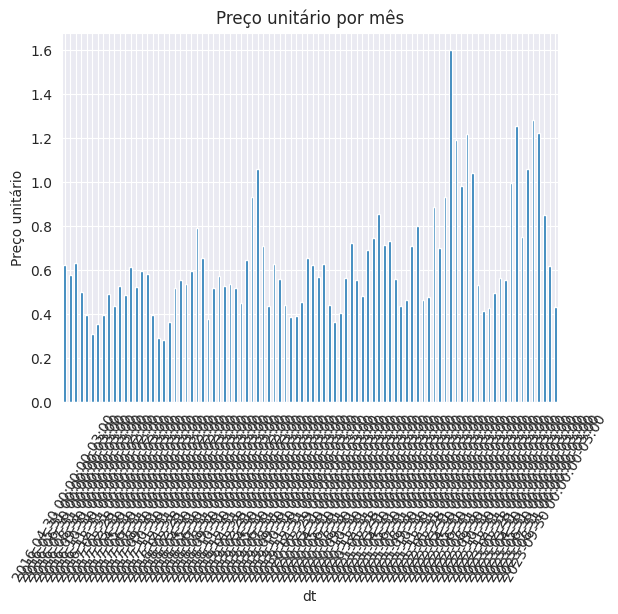

In [12]:
### Sum of 'Global_active_power' resampled over month
# Sum of 'Global_active_power' resampled over month
df['Preco_unitario'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Preço unitário')
plt.title('Preço unitário por mês')
plt.show()

Text(1.0, 0.75, '2021')

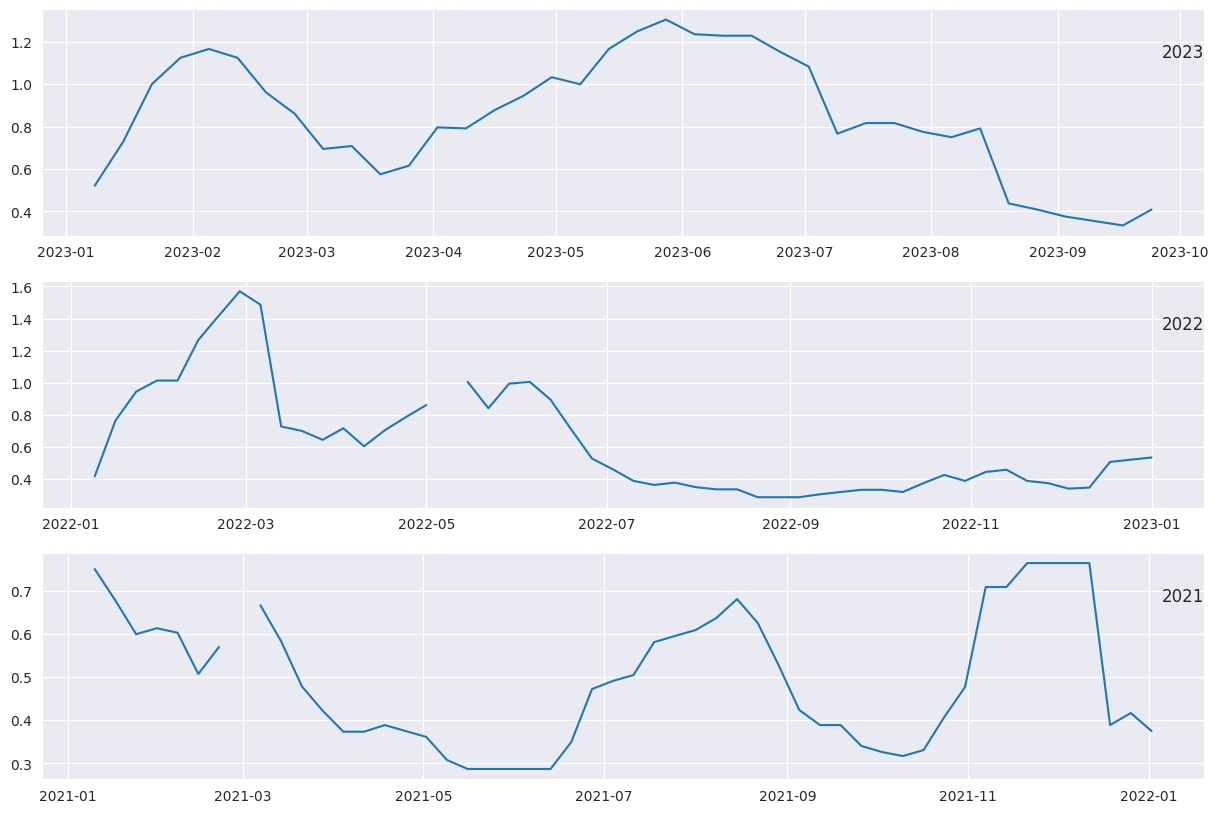

In [13]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]

precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')



### It is very important to note from above two plots that resampling over larger time inteval, will diminish the periodicity of system as we expect. This is important for machine learning feature engineering. 

 ## * It is seen from the above plots that the mean of 'Volage' over month is pretty much constant compared to other features. This is important again in feature selection.

In [14]:
## resampling over week and computing mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Global_reactive_power'

AttributeError: 'DataFrame' object has no attribute 'precip'

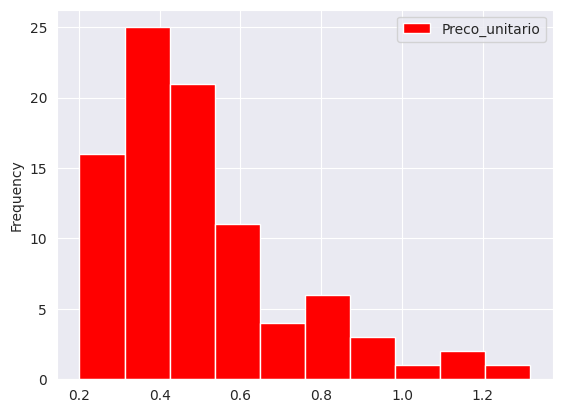

In [13]:
# Below I show hist plot of the mean of different feature resampled over month 
filtered_alface_crespa_roca.Preco_unitario.resample('M').mean().plot(kind='hist', color='r', legend=True )
filtered_alface_crespa_roca.precip.resample('M').mean().plot(kind='hist',color='b', legend=True)


plt.show()

ValueError: Could not interpret value `precip` for parameter `y`

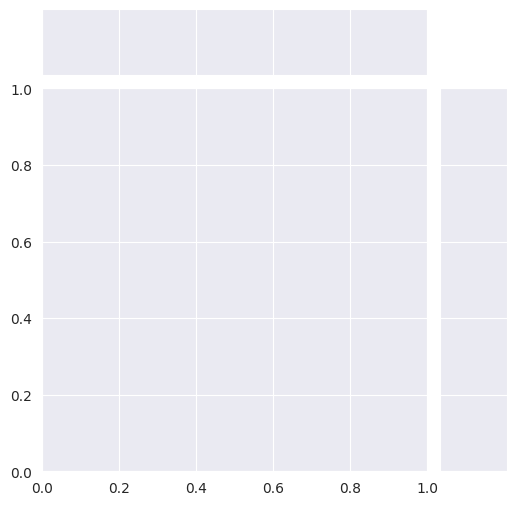

In [15]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = filtered_alface_crespa_roca.pct_change()
sns.jointplot(x='Preco_unitario', y='precip', data=data_returns)  

plt.show()

### * From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. This is important observation for machine learning purpose. 

In [ ]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

# Correlations among features

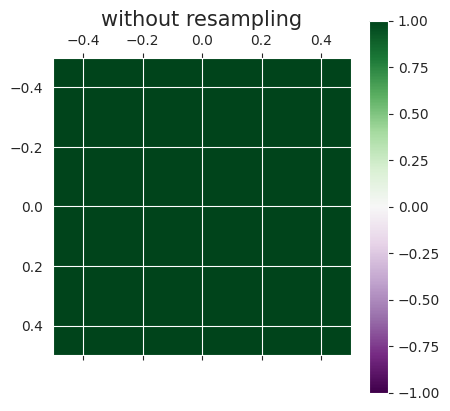

In [16]:
# Correlations among columns
plt.matshow(filtered_alface_crespa_roca.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

In [17]:
# Correlations of mean of features resampled over months


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

## * It is seen from above that with resampling techniques one can change the correlations among features. This is important for feature  engineering.

# Machine-Leaning: LSTM Data Preparation and feature engineering

### * I will apply recurrent nueral network (LSTM) which is best suited for time-seriers and sequential problem. This approach is the best if we have large data.  

### * I will frame the supervised learning problem as predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step.

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

### * In order to reduce the computation time, and also get a quick result to test the model.  One can resmaple the data over hour (the original data are given in minutes). This will reduce the size of data from 2075259 to 34589 but keep the overall strucure of data as shown in the above.   

In [32]:
## resampling of data over hour
#df_resample = df.resample('h').mean() 
#df_resample.shape

filtered_alface_crespa_roca.shape

(373, 1)

In [33]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = filtered_alface_crespa_roca.values

n_train_time = 248
train = values[:n_train_time, :]
test = values[n_train_time:, :]



In [41]:

## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 4, 4)
reframed_test = series_to_supervised(scaled_test, 4, 4)


# drop columns we don't want to predict
#reframed_train.drop(reframed_train.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
#reframed_test.drop(reframed_test.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

print(reframed_train.head())
print(reframed_test.head())

   var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  var1(t+1)  var1(t+2)  \
4   0.516188   0.286954   0.301005   0.292312  0.309024   0.320402   0.200662   
5   0.286954   0.301005   0.292312   0.309024  0.320402   0.200662   0.153176   
6   0.301005   0.292312   0.309024   0.320402  0.200662   0.153176   0.710373   
7   0.292312   0.309024   0.320402   0.200662  0.153176   0.710373   0.710373   
8   0.309024   0.320402   0.200662   0.153176  0.710373   0.710373   0.253507   

   var1(t+3)  
4   0.153176  
5   0.710373  
6   0.710373  
7   0.253507  
8   0.242141  
   var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  var1(t+1)  var1(t+2)  \
4   0.119559   0.119559   0.119559   0.119559  0.119559   0.194811   0.342303   
5   0.119559   0.119559   0.119559   0.119559  0.194811   0.342303   0.364879   
6   0.119559   0.119559   0.119559   0.194811  0.342303   0.364879   0.381434   
7   0.119559   0.119559   0.194811   0.342303  0.364879   0.381434   0.473241   
8   0.119559   0.1

### * Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current  time in hour (depending on resampling). 

# Splitting the rest of data to train and validation sets

### * First, I split the prepared dataset into train and test sets. To speed up the training of the model (for the sake of the demonstration), we will only train the model on the first year of data, then evaluate it on the next 3 years of data.

In [43]:
# split into train and test sets
#values = reframed.values

#n_train_time = 365*24
#train = values[:n_train_time, :]
#test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-4], reframed_train.values[:, -4]
test_X, test_y = reframed_test.values[:, :-4], reframed_test.values[:, -4]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(241, 1, 4) (241,) (118, 1, 4) (118,)


# Model architecture

### 1)  LSTM with 100 neurons in the first visible layer 
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power. 
### 5) The input shape will be 1 time step with 7 features.

### 6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.


Epoch 1/40
4/4 - 2s - loss: 0.0969 - val_loss: 0.3616 - 2s/epoch - 550ms/step
Epoch 2/40
4/4 - 0s - loss: 0.0618 - val_loss: 0.2458 - 75ms/epoch - 19ms/step
Epoch 3/40
4/4 - 0s - loss: 0.0370 - val_loss: 0.1579 - 83ms/epoch - 21ms/step
Epoch 4/40
4/4 - 0s - loss: 0.0220 - val_loss: 0.0997 - 77ms/epoch - 19ms/step
Epoch 5/40
4/4 - 0s - loss: 0.0162 - val_loss: 0.0703 - 88ms/epoch - 22ms/step
Epoch 6/40
4/4 - 0s - loss: 0.0174 - val_loss: 0.0608 - 86ms/epoch - 22ms/step
Epoch 7/40
4/4 - 0s - loss: 0.0196 - val_loss: 0.0590 - 86ms/epoch - 22ms/step
Epoch 8/40
4/4 - 0s - loss: 0.0188 - val_loss: 0.0606 - 79ms/epoch - 20ms/step
Epoch 9/40
4/4 - 0s - loss: 0.0166 - val_loss: 0.0654 - 81ms/epoch - 20ms/step
Epoch 10/40
4/4 - 0s - loss: 0.0157 - val_loss: 0.0717 - 80ms/epoch - 20ms/step
Epoch 11/40
4/4 - 0s - loss: 0.0152 - val_loss: 0.0764 - 82ms/epoch - 20ms/step
Epoch 12/40
4/4 - 0s - loss: 0.0151 - val_loss: 0.0773 - 77ms/epoch - 19ms/step
Epoch 13/40
4/4 - 0s - loss: 0.0146 - val_loss: 0.

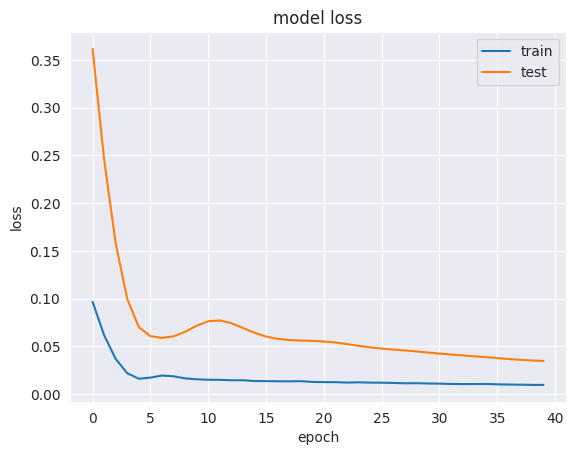

4/4 [==============================] - 0s 3ms/step
Test RMSE: 0.155


In [44]:

model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 4))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Note that in order to improve the model, one has to adjust epochs and batch_size.

In [50]:
dates = pd.to_datetime(filtered_alface_crespa_roca.index[255:]).strftime('%d-%m-%Y')
dates = dates.to_list()
dates

['02-07-2021',
 '09-07-2021',
 '16-07-2021',
 '23-07-2021',
 '30-07-2021',
 '06-08-2021',
 '13-08-2021',
 '20-08-2021',
 '27-08-2021',
 '03-09-2021',
 '10-09-2021',
 '17-09-2021',
 '24-09-2021',
 '30-09-2021',
 '08-10-2021',
 '15-10-2021',
 '22-10-2021',
 '29-10-2021',
 '04-11-2021',
 '12-11-2021',
 '19-11-2021',
 '26-11-2021',
 '03-12-2021',
 '09-12-2021',
 '17-12-2021',
 '23-12-2021',
 '30-12-2021',
 '07-01-2022',
 '14-01-2022',
 '21-01-2022',
 '28-01-2022',
 '04-02-2022',
 '10-02-2022',
 '18-02-2022',
 '25-02-2022',
 '04-03-2022',
 '11-03-2022',
 '18-03-2022',
 '25-03-2022',
 '31-03-2022',
 '07-04-2022',
 '14-04-2022',
 '22-04-2022',
 '29-04-2022',
 '13-05-2022',
 '20-05-2022',
 '27-05-2022',
 '03-06-2022',
 '10-06-2022',
 '15-06-2022',
 '24-06-2022',
 '01-07-2022',
 '08-07-2022',
 '15-07-2022',
 '22-07-2022',
 '29-07-2022',
 '05-08-2022',
 '12-08-2022',
 '19-08-2022',
 '25-08-2022',
 '31-08-2022',
 '09-09-2022',
 '16-09-2022',
 '23-09-2022',
 '30-09-2022',
 '06-10-2022',
 '14-10-20

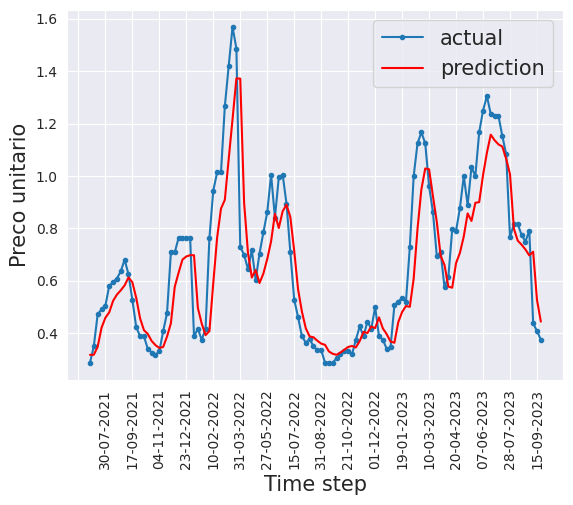

In [51]:


## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(124)]
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=90)
plt.plot(dates, inv_y[:124], marker='.', label="actual")
plt.plot(dates, inv_yhat[:124], 'r', label="prediction")
plt.ylabel('Preco unitario', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Final remarks

### * Here I have used the LSTM neural network which is now the state-of-the-art for sequencial problems. 

### * In order to reduce the computation time, and get some results quickly, I took the first year of data (resampled over hour) to train the model and the rest of data to test the model.  

### * I put together a very simple LSTM neural-network to show that one can obtain reasonable predictions. However numbers of rows is too high and as a result the computation is very time-consuming (even for the simple model in the above it took few mins to be run on  2.8 GHz Intel Core i7).  The Best is to write the last part of code using Spark (MLlib) running on GPU.  

### * Moreover, the neural-network architecture that I have designed is a toy model. It can be easily improved by adding CNN  and dropout layers.  The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).   